In [1]:
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import seaborn as sns
import spacy
import transformers
import torch

from datasets import Dataset
from hdbscan import HDBSCAN
from PIL import Image
from sentence_transformers import SentenceTransformer
from sklearn.cluster import (
    KMeans,
    AgglomerativeClustering
)
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM
)
from umap import UMAP
from wordcloud import WordCloud

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


## Read data

In [2]:
data_dir = "../data"
train_data_path = os.path.join(data_dir, 'train_data_llava.json')
test_data_path = os.path.join(data_dir, 'test_data_llava.json')
models_dir = "../models"

def generate_df_from_json(json_path):
  with open(json_path) as f:
    data: dict = json.load(f)
    data_formated= {'caption': [], 'label': []}
    for value in data.values():
      data_formated['caption'].append(value['caption'])
      data_formated['label'].append(value['label'])
  
  df = pd.DataFrame.from_dict(data_formated)
  return df

id2label = {
  0: 'Cultural_Religious',
  1: 'Fauna_Flora',
  2: 'Gastronomy',
  3: 'Nature',
  4: 'Sports',
  5: 'Urban_Rural'
}

label2id = {
  'Cultural_Religious': 0,
  'Fauna_Flora': 1,
  'Gastronomy': 2,
  'Nature': 3,
  'Sports': 4,
  'Urban_Rural': 5
}

train_df = generate_df_from_json(train_data_path)
train_df['Label'] = train_df['label'].replace(id2label)
test_df = generate_df_from_json(test_data_path)
test_df['Label'] = test_df['label'].replace(id2label)

#train_data = Dataset.from_pandas(train_df).train_test_split(test_size=0.15, seed=4999)
#test_data = Dataset.from_pandas(train_df)
#print(train_data)

## Generate embeddings

In [3]:
embedding_model = SentenceTransformer("all-MiniLM-L12-v2").to('cuda')
#embedding_model = SentenceTransformer("paraphrase-MiniLM-L12-v2").to('cuda')
#embedding_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2").to('cuda')

def generate_embeddings(df: pd.DataFrame, text_col: str):
    sentences = df[text_col].tolist()
    embeddings = embedding_model.encode(sentences)

    return embeddings
    
train_embeddings = generate_embeddings(train_df, 'caption')
test_embeddings = generate_embeddings(test_df, 'caption')

## Dimensionality reduction (UMAP)

We are going to reduce dimensonality:
1. For documents visualization, with 2 dimensions
2. For documents clustering, with more dimensions

### For documents visualization

In [4]:
viz_reducer = UMAP(n_neighbors=15, n_components=2, metric='cosine')
viz_train_reduced = viz_reducer.fit_transform(train_embeddings)

<Axes: xlabel='x', ylabel='y'>

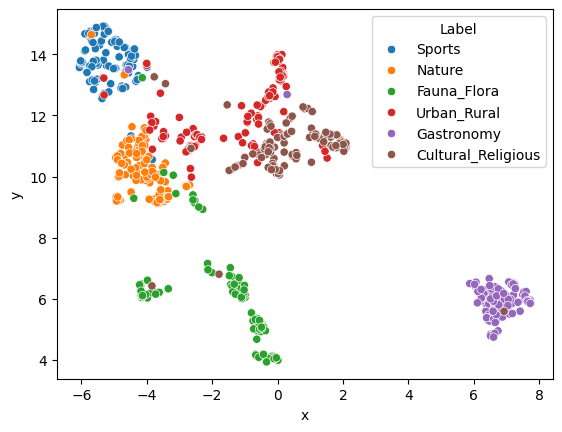

In [5]:
train_df['x'] = viz_train_reduced[:, 0]
train_df['y'] = viz_train_reduced[:, 1]
sns.scatterplot(
    train_df, x='x', y='y', 
    hue='Label', 
    palette=sns.color_palette("tab10", n_colors=6)
)

### For clustering

In [6]:
reducer = UMAP(n_neighbors=15, n_components=20, metric='cosine')
train_reduced = reducer.fit_transform(train_embeddings)

## Clustering

### HDBSCAN

In [7]:
clusterer = HDBSCAN(min_cluster_size=20, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
clusterer.fit(train_reduced)

HDBSCAN(min_cluster_size=20, prediction_data=True)

/tmp/ipykernel_16045/1165245163.py:2: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  ax = sns.scatterplot(


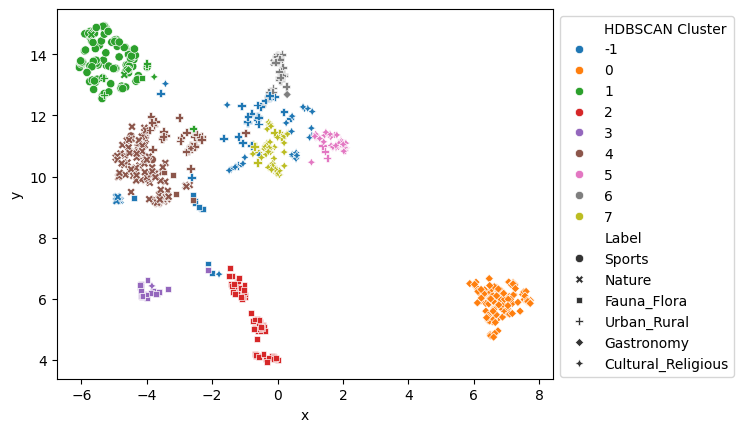

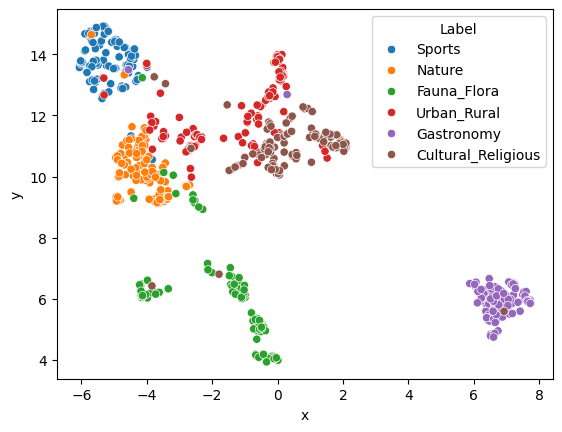

In [8]:
train_df['HDBSCAN Cluster'] = clusterer.labels_
ax = sns.scatterplot(
    train_df, x='x', y='y', hue='HDBSCAN Cluster', style='Label',
    palette=sns.color_palette("tab10", n_colors=10)
)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Position outside the plot
plt.show()

sns.scatterplot(
    train_df, x='x', y='y', hue='Label', 
    palette=sns.color_palette("tab10", n_colors=6)
)
plt.show()

<Axes: ylabel='$\\lambda$ value'>

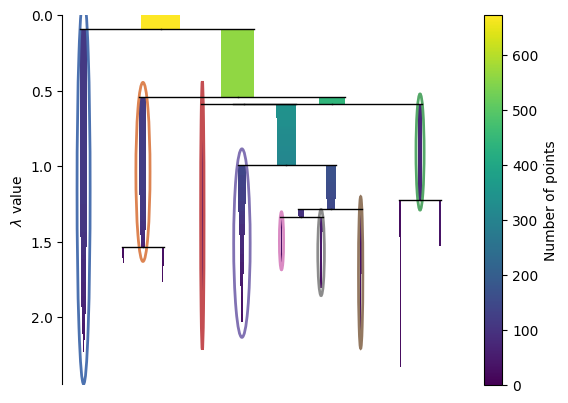

In [9]:
clusterer.condensed_tree_.plot(
    select_clusters=True,
    selection_palette=sns.color_palette('deep', 8)
)

### KMeans

In [10]:
kmeans_clusterer = AgglomerativeClustering(n_clusters=6)#, n_init=20, max_iter=10000)
kmeans_clusterer.fit(train_reduced)

AgglomerativeClustering(n_clusters=6)

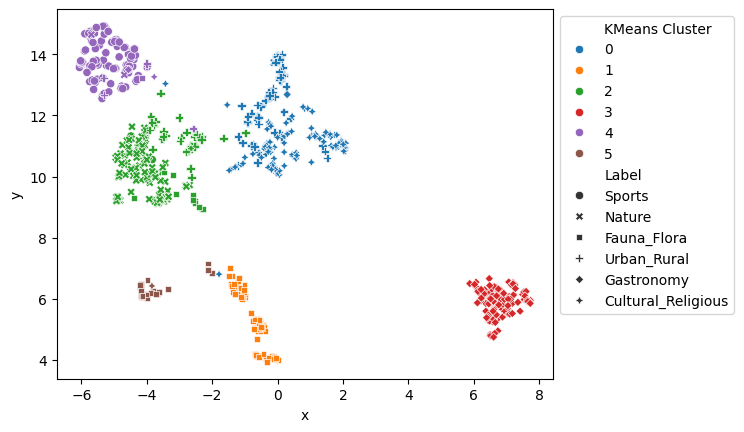

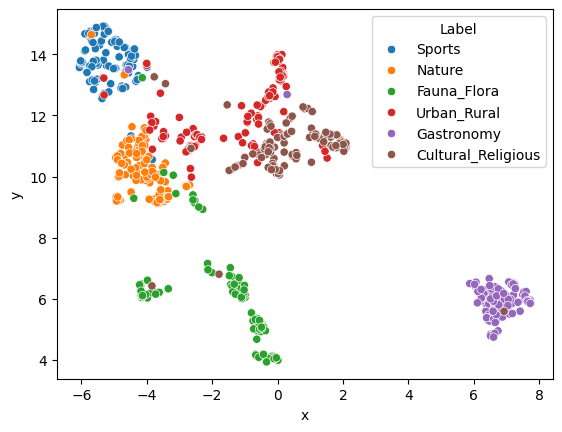

In [11]:
train_df['KMeans Cluster'] = kmeans_clusterer.labels_
ax=sns.scatterplot(
    train_df, x='x', y='y', hue='KMeans Cluster', style='Label',
    palette=sns.color_palette("tab10", n_colors=6)
)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Position outside the plot
plt.show()

sns.scatterplot(
    train_df, x='x', y='y', hue='Label', 
    palette=sns.color_palette("tab10", n_colors=6)
)
plt.show()

## Clusters BoW

Cluster 0


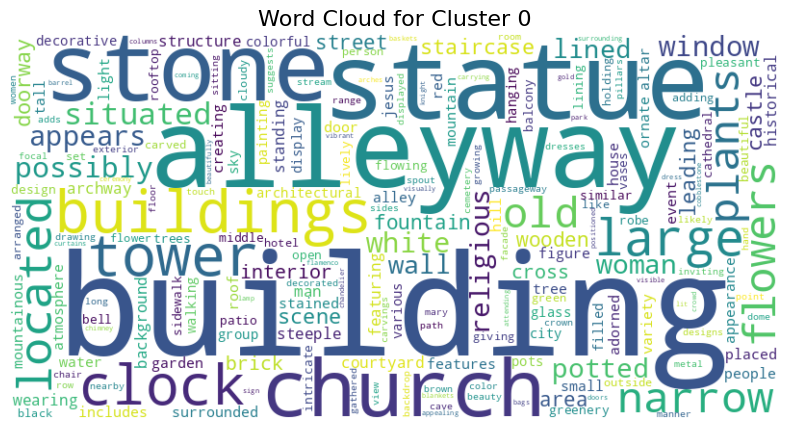

building: 0.4892
alleyway: 0.2883
statue: 0.2714
stone: 0.2314
church: 0.2272
buildings: 0.2225
tower: 0.2148
clock: 0.2035
large: 0.1606
located: 0.1448


Cluster 1


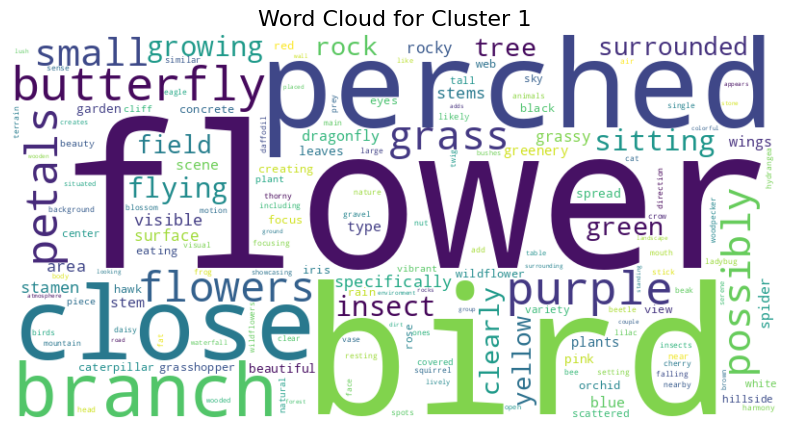

flower: 0.4742
bird: 0.3680
perched: 0.3330
close: 0.3142
branch: 0.2453
butterfly: 0.1752
purple: 0.1699
petals: 0.1577
flowers: 0.1456
grass: 0.1293


Cluster 2


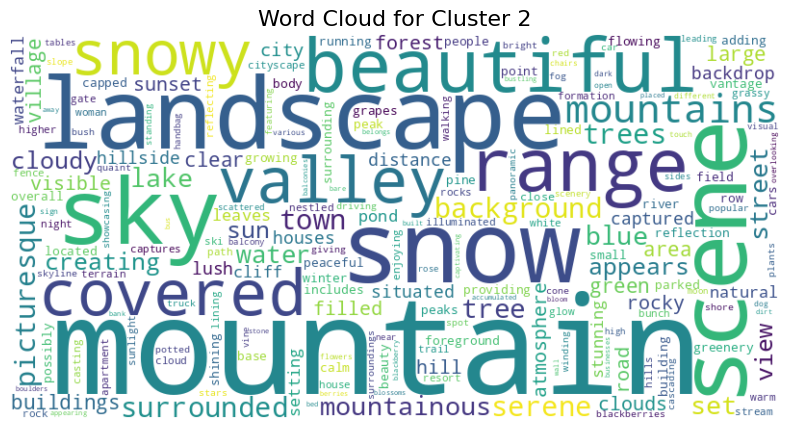

mountain: 0.5286
snow: 0.2538
landscape: 0.2448
scene: 0.2317
sky: 0.2124
beautiful: 0.2021
range: 0.2017
valley: 0.1493
covered: 0.1476
snowy: 0.1387


Cluster 3


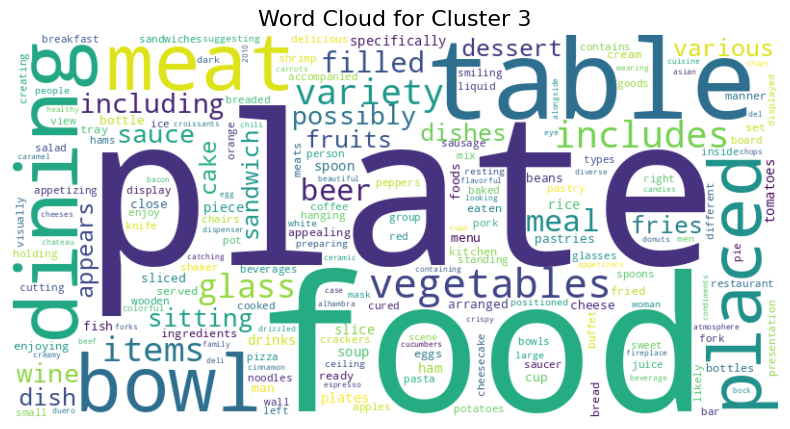

plate: 0.5811
food: 0.4548
table: 0.3761
dining: 0.2021
meat: 0.1769
bowl: 0.1705
placed: 0.1456
vegetables: 0.1453
includes: 0.1162
variety: 0.1124


Cluster 4


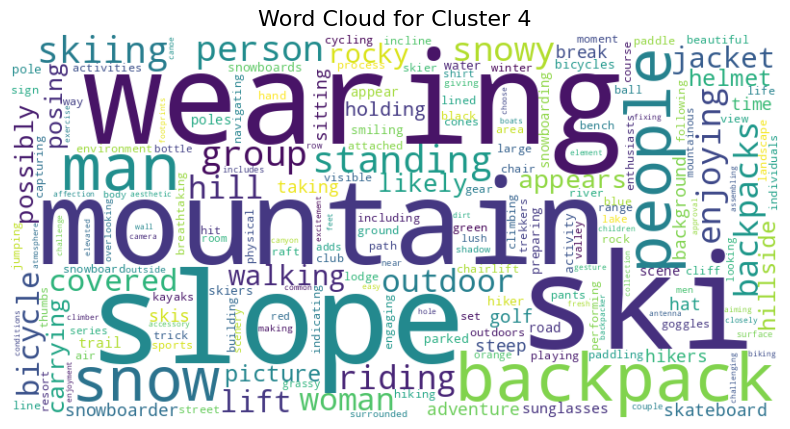

ski: 0.2961
wearing: 0.2775
slope: 0.2650
mountain: 0.2629
backpack: 0.2376
man: 0.2337
people: 0.2142
snow: 0.2104
standing: 0.1814
skiing: 0.1714


Cluster 5


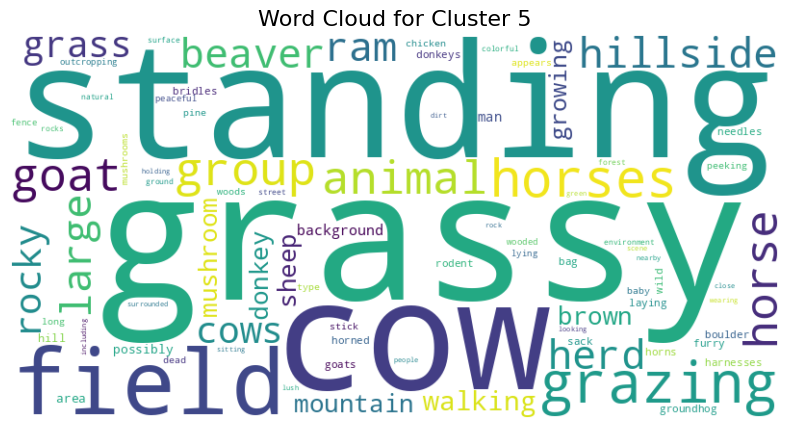

grassy: 0.4451
standing: 0.3330
cow: 0.3089
field: 0.2939
grazing: 0.2648
horses: 0.2207
group: 0.1809
animal: 0.1765
goat: 0.1765
horse: 0.1765




In [12]:
# Step 1: Combine all documents in the same cluster into a single document
clustered_docs = train_df.groupby('KMeans Cluster')['caption'].apply(' '.join).reset_index()
clustered_docs['caption'] = clustered_docs['caption'].str.replace('image', '')
clustered_docs['caption'] = clustered_docs['caption'].str.replace('shows', '')

# Step 2: Calculate the TF-IDF for the combined documents
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(clustered_docs['caption'])

# Step 3: Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Step 4: Extract the top 10 words with the highest TF-IDF score for each cluster
top_n = 10
clusters_words = {}
for idx, row in enumerate(tfidf_matrix):
    representative_words = []
    cluster = clustered_docs['KMeans Cluster'][idx]
    print(f"Cluster {cluster}")
    # Get the TF-IDF scores for the row and corresponding feature names
    tfidf_scores = zip(feature_names, row.toarray().flatten())
    # Convert to dictionary (word: tf-idf score)
    tfidf_dict = {word: score for word, score in tfidf_scores}
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_dict)
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster}', fontsize=16)
    plt.show()
    # Sort by TF-IDF score in descending order and get the top N words
    tfidf_scores = zip(feature_names, row.toarray().flatten())
    sorted_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)[:top_n]
    for word, score in sorted_scores:
        representative_words.append(word)
        print(f"{word}: {score:.4f}")
    print("\n")
    clusters_words[cluster] = representative_words
    

## Zero-shot cluster classification

In [17]:
llama_model_id = 'meta-llama/Llama-2-7b-hf'
labels = ['Sports', 'Nature', 'Urban and rural', 'Flora and fauna', 'Gastronomy', 'Cultural and religious']

def generate_zero_shot_classification_prompt(words, labels):
    prompt = f"""The following words are the more representative within a cluster. \
Given these words, classify the cluster into one of the categories: \
{', '.join(labels)}\n\nWords: {', '.join(words)}"""
    return prompt

def generate_label_generator_prompt(words):
    prompt = f"""The following words are the more representative within a cluster. \
Given these words, generate a label for this cluster. Keep in mind that the cluster \
label will represent the profile of the visitor who took the picture: \
\n\nWords: {', '.join(words)}"""
    return prompt

def classify_text(model, tokenizer, words, labels, max_length=100):
    prompt = generate_zero_shot_classification_prompt(words, labels)
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(inputs["input_ids"], max_length=max_length)

    print("Prompt: ", prompt)
    # Decode the generated text
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract the category from the generated text
    print("Generated text: ", generated_text)
    category = generated_text.split("Category:")[-1].strip().split('\n')[0]
    return category

def generate_label(model, tokenizer, words, labels, max_length=100):
    prompt = generate_label_generator_prompt(words, labels)
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(inputs["input_ids"], max_length=max_length)

    # Decode the generated text
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract the category from the generated text
    category = generated_text.split("Category:")[-1].strip().split('\n')[0]
    return category


In [ ]:

# Load the tokenizer and model
print("Tokenizer ...")
tokenizer = AutoTokenizer.from_pretrained(llama_model_id)
print("Model ...")
model = AutoModelForCausalLM.from_pretrained(
    llama_model_id,
    load_in_4bit=True,
    device_map="auto",  # This automatically places the model on the available GPUs
    torch_dtype=torch.float16,  # You can use bfloat16 or float16 for better memory usage
)


In [18]:

for cluster, words in clusters_words.items():
    category = classify_text(model, tokenizer, words, labels)

    

/home/nacho/Proyects/image-topic-clustering/venv/lib/python3.12/site-packages/transformers/generation/utils.py:1797: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


The following words are the more representative within a cluster. Given these words, classify the cluster into one of the categories: Sports, Nature, Urban and rural, Flora and fauna, Gastronomy, Cultural and religious

Words: building, alleyway, statue, stone, church, buildings, tower, clock, large, located, street, monument, square, towering, monumental, spire, spacious, cathedral, spacious, church
['building', 'alleyway', 'statue', 'stone', 'church', 'buildings', 'tower', 'clock', 'large', 'located'] The following words are the more representative within a cluster. Given these words, classify the cluster into one of the categories: Sports, Nature, Urban and rural, Flora and fauna, Gastronomy, Cultural and religious
The following words are the more representative within a cluster. Given these words, classify the cluster into one of the categories: Sports, Nature, Urban and rural, Flora and fauna, Gastronomy, Cultural and religious

Words: flower, bird, perched, close, branch, butterf